# Finding Anomalies using the MNIST dataset

This notebook will attempt to find anomalies using convolutional autoencoders on the MNIST dataset. I will test the number "4" as an anomaly by removing it from the training set, and attempt to find the anomalies in two ways:

1. By looking at the loss on each reconstructed 4 on the test set to see if the reconstructed loss is higher than numbers that were part of the test set.
2. Do PCA, umap or TSNI on the bottleck layer to find anomalies -- I will need some help on this

### Imports

In [0]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, LeakyReLU, Flatten, Reshape, BatchNormalization
from keras.models import Model
from keras import backend as K

In [0]:
Flatten?

In [0]:
from keras.datasets import mnist
import numpy as np

In [0]:
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split

In [0]:
import matplotlib.pyplot as plt

In [5]:
!pip install umap-learn

    100% |████████████████████████████████| 2.4MB 7.6MB/s 
    100% |████████████████████████████████| 16.1MB 1.8MB/s 
  Running setup.py bdist_wheel for umap-learn ... - done
  Stored in directory: /root/.cache/pip/wheels/e2/ef/6a/6f6b69240a773f5931616a578b6b5e5c3f565737dab9f45ca4
Successfully built umap-learn


In [0]:
import umap

In [0]:
import seaborn as sns

sns.set(style='white', rc={'figure.figsize':(12,8)})

### Construct Autoencoder

In [0]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format, like MNIST

In [0]:
#Encoding Section
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

In [0]:
#Decoding Section
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [0]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy') #this is the loss recommended by Josh

### Import and Resize Data

In [9]:
(x_train, x_train_label), (x_test, x_test_label) = mnist.load_data()

#– train[i][0] or test[i][0]: i-th handwritten image
#– train[i][1] or test[i][1]: i-th label

11501568/11490434 [==============================] - 2s 0us/step


In [10]:
x_train_label #Yay! I figured out where the labels are :D

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [0]:
x_train_cleaned = x_train[np.where(x_train_label !=4)]
x_label_cleaned = x_train_label[np.where(x_train_label !=4)]

In [12]:
len(x_train_cleaned)

54158

This removed ~10% of the dataset, and is still significantly longer than the training set. I'm going to check how many "4"s are in the test set, so we can see how many anomalies we should find.

In [13]:
len(x_test[np.where(x_test_label == 4)])

982

Now, I'll reshape the data

In [0]:
x_train = x_train_cleaned.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

### Train the Autoencoder

The Chollet tutorial just used the training data as validation data, but I'd like to actually validate on seperate data to avoid overfitting, so I'm going to use 80% of the training set for training and 20% of the training set for validation. 

In [0]:
train_X,valid_X,train_label,valid_label = train_test_split(x_train,
                                                           x_label_cleaned, 
                                                           test_size=0.2, 
                                                           random_state=13)

I'm going to try first without early stopping example, and I'll check the loss after.

In [16]:
autoencoder_train = autoencoder.fit(train_X, train_X,
                                    epochs=100,
                                    batch_size=128,
                                    shuffle=True,
                                    validation_data=(valid_X, valid_X),
                                    callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 43326 samples, validate on 10832 samples
Epoch 1/100
43326/43326 [==============================] - 7s 164us/step - loss: 0.2228 - val_loss: 0.1530
Epoch 2/100
43326/43326 [==============================] - 6s 133us/step - loss: 0.1414 - val_loss: 0.1335
Epoch 3/100
43326/43326 [==============================] - 6s 129us/step - loss: 0.1279 - val_loss: 0.1252
Epoch 4/100
43326/43326 [==============================] - 6s 127us/step - loss: 0.1216 - val_loss: 0.1190
Epoch 5/100
43326/43326 [==============================] - 5s 125us/step - loss: 0.1174 - val_loss: 0.1152
Epoch 6/100
43326/43326 [==============================] - 5s 124us/step - loss: 0.1142 - val_loss: 0.1125
Epoch 7/100
43326/43326 [==============================] - 5s 125us/step - loss: 0.1118 - val_loss: 0.1107
Epoch 8/100
43326/43326 [==============================] - 5s 123us/step - loss: 0.1097 - val_loss: 0.1085
Epoch 9/100
43326/43326 [==============================] - 5s 123us/step - loss: 0.1080 - val_

Now I have encoder that's trained without any "4"s. Let's look at the loss over time

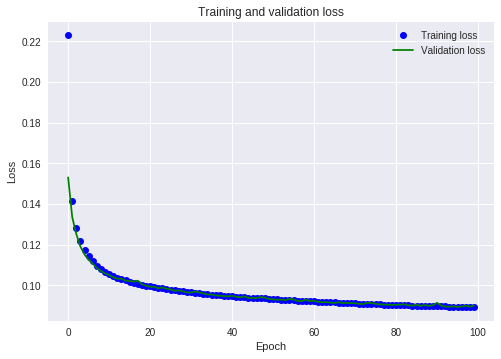

In [17]:
loss = autoencoder_train.history['loss'] #this recovers the loss function from the training set
val_loss = autoencoder_train.history['val_loss'] #this recovers the loss function from the validation set
epochs = range(100)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

That looks pretty good! If I have the time, I'll try with an early stop, but so far it hasn't overtrained.

### Test the Autoencoder

I will test on the dataset that still has the fours preserved. I would like to see how the average loss is for the fours vs. the other numbers. Hypothesis: It should be higher.

In [110]:
from keras import 

Object `Flatten` not found.


In [0]:
decoded_imgs = autoencoder.predict(x_test)

In [19]:
type(decoded_imgs)

numpy.ndarray

To test, use model.evaluate() function. This can also provide a measurement called accuracy, but for now, I'm going to work with just the loss.

In [20]:
test_loss = autoencoder.evaluate(x_test, x_test)

10000/10000 [==============================] - 1s 97us/step


In [21]:
test_loss

0.09028160860538482

This is worse than the final loss on the training set. Let me see if I can look at loss one by one.

In [22]:
individual_test_loss = []

for ii in range(len(decoded_imgs)):
  x_test_reshape = np.expand_dims(x_test[ii], axis=0) #This is because the input argument needs to have 4 dimensions
  test_loss = autoencoder.evaluate(x_test_reshape, x_test_reshape)
  individual_test_loss.append(test_loss)

1/1 [==============================] - 0s 5ms/step


In [23]:
len(individual_test_loss)

10000

In [24]:
individual_test_loss[0]

0.0665726438164711

In [0]:
individual_test_loss = np.array(individual_test_loss)

It does seem that that worked to get the test loss for individual pieces. Now I'm going to try to print out the average test loss for each number to see if there is a difference for "4"

In [26]:
print(max(x_test_label), min(x_test_label))

(9, 0)


In [27]:
for ii in range(10):
  
  loss_avg = np.mean(individual_test_loss[np.where(x_test_label == ii)])
  print('The average loss for {} is {}'.format(ii, loss_avg))

The average loss for 0 is 0.100640124075
The average loss for 1 is 0.0424182779332
The average loss for 2 is 0.103016976614
The average loss for 3 is 0.0987064758629
The average loss for 4 is 0.101843183796
The average loss for 5 is 0.0973425349597
The average loss for 6 is 0.0961697758963
The average loss for 7 is 0.0740118159039
The average loss for 8 is 0.112036161262
The average loss for 9 is 0.0850935957336


Hmmm, that didn't give a higher avg. loss for 4. Let me check if the maximal losses were worse?

In [28]:
for ii in range(10):
  
  loss_max = np.max(individual_test_loss[np.where(x_test_label == ii)])
  print('The maximal loss for {} is {}'.format(ii, loss_max))

The maximal loss for 0 is 0.199407219887
The maximal loss for 1 is 0.133419319987
The maximal loss for 2 is 0.180984169245
The maximal loss for 3 is 0.199312508106
The maximal loss for 4 is 0.193709179759
The maximal loss for 5 is 0.154651090503
The maximal loss for 6 is 0.222420826554
The maximal loss for 7 is 0.180032342672
The maximal loss for 8 is 0.205204904079
The maximal loss for 9 is 0.175539597869


Maybe "4" has the widest range of losses?

In [29]:
for ii in range(10):
  
  loss_range = np.max(individual_test_loss[np.where(x_test_label == ii)]) - np.min(individual_test_loss[np.where(x_test_label == ii)])
  print('The loss range for {} is {}'.format(ii, loss_range))

The loss range for 0 is 0.144544180483
The loss range for 1 is 0.112823387608
The loss range for 2 is 0.125570639968
The loss range for 3 is 0.146288722754
The loss range for 4 is 0.133687101305
The loss range for 5 is 0.0939629226923
The loss range for 6 is 0.167774178088
The loss range for 7 is 0.140738826245
The loss range for 8 is 0.155128516257
The loss range for 9 is 0.127478279173


Weirdly enough, "4" performs better than something else everytime. I wonder if this is because "4" is very similar to "9" in this person's handwriting. It does seem that 8 and 0 are naturally outliers, and I think it would be interesting to rerun this analysis on one of them. I will do "0" because "8" is somewhat similar to "3" in this person's handwriting.

### Retrain Autoencoder for 0

At first I thought that I needed to rewrite every layer to get the enoded layer or bottleneck layer, but I'm pretty sure I can call that afterwards with `encoded`. I guess I'll find out!

In [8]:
(x_train, x_train_label), (x_test, x_test_label) = mnist.load_data()

11501568/11490434 [==============================] - 1s 0us/step


In [0]:
x_train_cleaned = x_train[np.where(x_train_label !=0)]
x_label_cleaned = x_train_label[np.where(x_train_label !=0)]

In [10]:
len(x_train_cleaned)

54077

In [11]:
len(x_test[np.where(x_test_label == 0)])

980

The amount of "0"s is similar enough in both the training and test sets to run comparisons.

In [0]:
x_train = x_train_cleaned.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [0]:
train_X,valid_X,train_label,valid_label = train_test_split(x_train,
                                                           x_label_cleaned, 
                                                           test_size=0.2, 
                                                           random_state=13)

I think I need to rerun the entire autoencoder! That's why the loss (see output of plot below) is starting off so small in the very first step. I'll do that now.

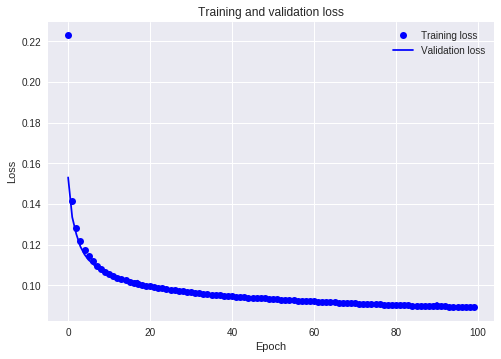

In [36]:
#From a previous run where I didn't realize I needed to reset the autoencoder

loss = autoencoder_train.history['loss'] #this recovers the loss function from the training set
val_loss = autoencoder_train.history['val_loss'] #this recovers the loss function from the validation set
epochs = range(100)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
#Encoding Section
y = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
y = MaxPooling2D((2, 2), padding='same')(y)
y = Conv2D(8, (3, 3), activation='relu', padding='same')(y)
y = MaxPooling2D((2, 2), padding='same')(y)
y = Conv2D(8, (3, 3), activation='relu', padding='same')(y)
encoded_0 = MaxPooling2D((2, 2), padding='same')(y)

In [0]:
#Decoding Section
y = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded_0)
y = UpSampling2D((2, 2))(y)
y = Conv2D(8, (3, 3), activation='relu', padding='same')(y)
y = UpSampling2D((2, 2))(y)
y = Conv2D(16, (3, 3), activation='relu')(y)
y = UpSampling2D((2, 2))(y)
decoded_0 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(y)

In [0]:
autoencoder = Model(input_img, decoded_0)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy') #this is the loss recommended by Josh

In [40]:
autoencoder_train = autoencoder.fit(train_X, train_X,
                                    epochs=100,
                                    batch_size=128,
                                    shuffle=True,
                                    validation_data=(valid_X, valid_X),
                                    callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 43261 samples, validate on 10816 samples
Epoch 1/100
43261/43261 [==============================] - 6s 146us/step - loss: 0.2252 - val_loss: 0.1548
Epoch 2/100
43261/43261 [==============================] - 6s 128us/step - loss: 0.1435 - val_loss: 0.1352
Epoch 3/100
43261/43261 [==============================] - 5s 127us/step - loss: 0.1300 - val_loss: 0.1257
Epoch 4/100
43261/43261 [==============================] - 5s 126us/step - loss: 0.1225 - val_loss: 0.1197
Epoch 5/100
43261/43261 [==============================] - 6s 128us/step - loss: 0.1177 - val_loss: 0.1161
Epoch 6/100
43261/43261 [==============================] - 5s 126us/step - loss: 0.1143 - val_loss: 0.1132
Epoch 7/100
43261/43261 [==============================] - 5s 124us/step - loss: 0.1120 - val_loss: 0.1110
Epoch 8/100
43261/43261 [==============================] - 6s 129us/step - loss: 0.1100 - val_loss: 0.1091
Epoch 9/100
43261/43261 [==============================] - 5s 126us/step - loss: 0.1085 - val_

That already looks better on the first loss. Now I'll double check the loss as a function of epoch.

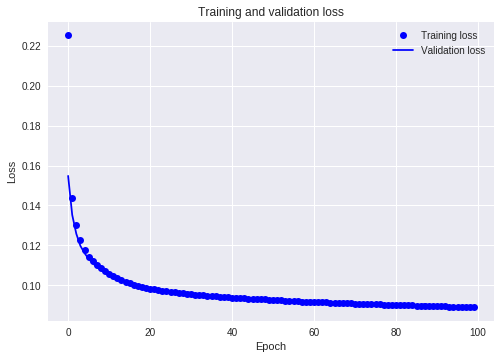

In [41]:
loss = autoencoder_train.history['loss'] #this recovers the loss function from the training set
val_loss = autoencoder_train.history['val_loss'] #this recovers the loss function from the validation set
epochs = range(100)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

That looks much better. Now I'll run this new encoder (missing 0 in training) on the test set.

In [0]:
decoded_imgs = autoencoder.predict(x_test)

In [43]:
individual_test_loss = []

for ii in range(len(decoded_imgs)):
  x_test_reshape = np.expand_dims(x_test[ii], axis=0) #This is because the input argument needs to have 4 dimensions
  test_loss = autoencoder.evaluate(x_test_reshape, x_test_reshape)
  individual_test_loss.append(test_loss)

1/1 [==============================] - 0s 5ms/step


In [0]:
individual_test_loss = np.array(individual_test_loss)

In [45]:
for ii in range(10):
  
  loss_avg = np.mean(individual_test_loss[np.where(x_test_label == ii)])
  print('The average loss for {} is {}'.format(ii, loss_avg))

The average loss for 0 is 0.110916175465
The average loss for 1 is 0.0420913923138
The average loss for 2 is 0.103869889913
The average loss for 3 is 0.0991249332813
The average loss for 4 is 0.0886523632139
The average loss for 5 is 0.0986597467832
The average loss for 6 is 0.0953782166671
The average loss for 7 is 0.0747080059316
The average loss for 8 is 0.111512777233
The average loss for 9 is 0.0845219997063


In [46]:
for ii in range(10):
  
  loss_max = np.max(individual_test_loss[np.where(x_test_label == ii)])
  print('The maximal loss for {} is {}'.format(ii, loss_max))

The maximal loss for 0 is 0.228629127145
The maximal loss for 1 is 0.122818693519
The maximal loss for 2 is 0.189560458064
The maximal loss for 3 is 0.220966413617
The maximal loss for 4 is 0.170500516891
The maximal loss for 5 is 0.165876284242
The maximal loss for 6 is 0.177622690797
The maximal loss for 7 is 0.166851341724
The maximal loss for 8 is 0.208350554109
The maximal loss for 9 is 0.155035912991


In [47]:
for ii in range(10):
  
  loss_range = np.max(individual_test_loss[np.where(x_test_label == ii)]) - np.min(individual_test_loss[np.where(x_test_label == ii)])
  print('The loss range for {} is {}'.format(ii, loss_range))

The loss range for 0 is 0.163718178868
The loss range for 1 is 0.103039409965
The loss range for 2 is 0.126836448908
The loss range for 3 is 0.164856895804
The loss range for 4 is 0.11637698859
The loss range for 5 is 0.101887136698
The loss range for 6 is 0.124554309994
The loss range for 7 is 0.125241957605
The loss range for 8 is 0.15887741372
The loss range for 9 is 0.10867017135


So in order to use reconstruction loss as an anomaly detector, we need to be looking for something that is already dissimilar to most other things. Ideally, I should compare these numbers to losses when the full dataset is trained on as well, and if I have time, I'll do that before today's meeting.

After meeting with Josh, I'm going to try the zeros with a different loss function. Josh recommended looking into Leaky ReLU.

![Leaky ReLU](https://qph.fs.quoracdn.net/main-qimg-810df1b8981a83fd719c1085f74b4205-c)

Non-leaky rectified linear units have a problem called “dying”. If the dot product of the input to a ReLU with its weights is negative, the output is 0. The gradient of max(x,0) is 0 when the output is 0. This can be avoided using Leaky ReLU where the gradient is never zero (except for at 0?)

This is a helpful explanation of setting the correct parameters for the `Dense` layer: https://www.quora.com/How-can-I-choose-the-number-of-hidden-layers-and-the-neurons-in-each-layer-when-building-a-dense-network

In [191]:
#Encoding Section
z = Conv2D(16, (3, 3), padding='same')(input_img)
z = BatchNormalization()(z)
z = LeakyReLU()(z)
z = MaxPooling2D((2, 2), padding='same')(z)
print(np.shape(z))
z = Conv2D(8, (3, 3), padding='same')(z)
z = BatchNormalization()(z)
z = LeakyReLU()(z)
z = MaxPooling2D((2, 2), padding='same')(z)
print(np.shape(z))
z = Conv2D(8, (3, 3), padding='same')(z)
z = BatchNormalization()(z)
z = LeakyReLU()(z)
z = MaxPooling2D((2, 2), padding='same')(z)
z = BatchNormalization()(z)
print(np.shape(z))
z = Dense(4)(z) #I tried 4 before with nonconverging loss
z = LeakyReLU()(z)
print(np.shape(z))
encoder_leaky = Flatten()(z)
print(np.shape(encoder_leaky))

(?, 14, 14, 16)
(?, 7, 7, 8)
(?, 4, 4, 8)
(?, 4, 4, 4)
(?, ?)


In [0]:
Conv2D?

**Question for Josh**: see comment below in first line of decoding section

In [0]:
#Decoding Section
# z = UpSampling2D((2, 2))(encoder_leaky) The Dense layer doesn't appear to need UpSampling -- why not?
z = Reshape((4, 4, 4))(encoder_leaky)
z = Conv2D(8, (3, 3), padding='same')(z)
z = BatchNormalization()(z)
z = LeakyReLU()(z)
z = UpSampling2D((2, 2))(z)
z = Conv2D(8, (3, 3), padding='same')(z)
z = BatchNormalization()(z)
z = LeakyReLU()(z)
z = UpSampling2D((2, 2))(z)
z = Conv2D(16, (3, 3))(z)
z = BatchNormalization()(z)
z = LeakyReLU()(z)
z = UpSampling2D((2, 2))(z)
decoder_leaky = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(z)

In [0]:
autoencoder = Model(input_img, decoder_leaky)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy') #im trying for Poisson because it seems that it would be the opp of binary

In [161]:
autoencoder_train = autoencoder.fit(train_X, train_X,
                                    epochs=100,
                                    batch_size=128,
                                    shuffle=True,
                                    validation_data=(valid_X, valid_X),
                                    callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 43261 samples, validate on 10816 samples
Epoch 1/100
43261/43261 [==============================] - 12s 267us/step - loss: 0.2244 - val_loss: 0.1965
Epoch 2/100
43261/43261 [==============================] - 10s 237us/step - loss: 0.1436 - val_loss: 0.1330
Epoch 3/100
43261/43261 [==============================] - 10s 237us/step - loss: 0.1297 - val_loss: 0.1246
Epoch 4/100
43261/43261 [==============================] - 10s 237us/step - loss: 0.1218 - val_loss: 0.1180
Epoch 5/100
43261/43261 [==============================] - 10s 236us/step - loss: 0.1170 - val_loss: 0.1152
Epoch 6/100
43261/43261 [==============================] - 10s 235us/step - loss: 0.1136 - val_loss: 0.1155
Epoch 7/100
43261/43261 [==============================] - 10s 234us/step - loss: 0.1111 - val_loss: 0.1097
Epoch 8/100
43261/43261 [==============================] - 10s 234us/step - loss: 0.1090 - val_loss: 0.1080
Epoch 9/100
43261/43261 [==============================] - 10s 238us/step - loss: 0.10

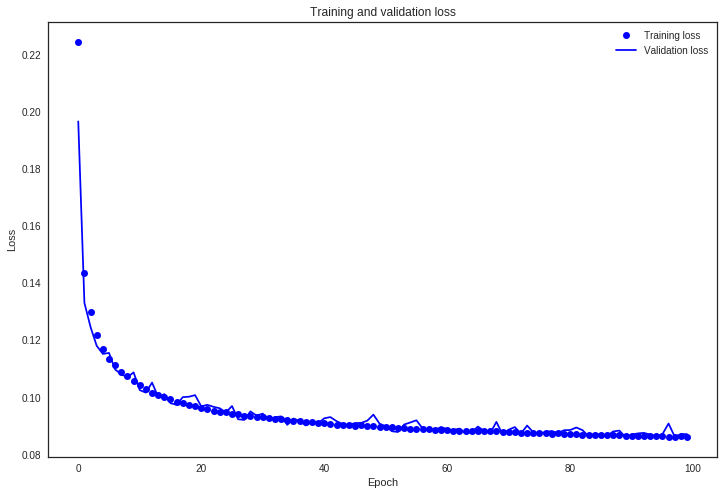

In [162]:
loss = autoencoder_train.history['loss'] #this recovers the loss function from the training set
val_loss = autoencoder_train.history['val_loss'] #this recovers the loss function from the validation set
epochs = range(100)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

There is still more learning to be done, even with the `Dense` layer downsampled to 2. **Ask Josh about this**

In [0]:
decoded_imgs = autoencoder.predict(x_test)

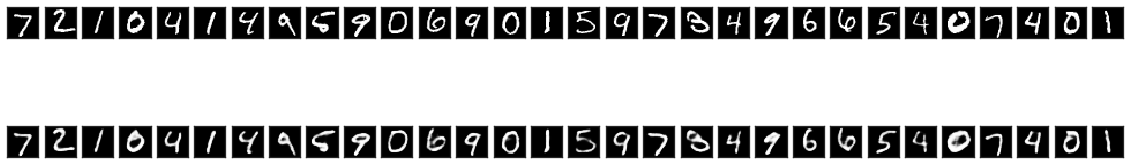

In [164]:
n = 30
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Zero is reconstructing a little worse for wear with the dense layer and starting to look like 8 occasionally. Here's what's weird --  there is no 8 or 3 in the first 10? and no 3s in the first 30? Maybe there are less 8s and 3 in MNIST.

In [116]:
individual_test_loss = []

for ii in range(len(decoded_imgs)):
  x_test_reshape = np.expand_dims(x_test[ii], axis=0) #This is because the input argument needs to have 4 dimensions
  test_loss = autoencoder.evaluate(x_test_reshape, x_test_reshape)
  individual_test_loss.append(test_loss)

1/1 [==============================] - 0s 7ms/step


In [0]:
individual_test_loss = np.array(individual_test_loss)

In [119]:
for ii in range(10):
  
  loss_avg = np.mean(individual_test_loss[np.where(x_test_label == ii)])
  print('The average loss for {} is {}'.format(ii, loss_avg))

The average loss for 0 is 0.22521365881
The average loss for 1 is 0.0968248369541
The average loss for 2 is 0.198111946117
The average loss for 3 is 0.1900317059
The average loss for 4 is 0.164359008874
The average loss for 5 is 0.178615177927
The average loss for 6 is 0.188856482801
The average loss for 7 is 0.149868719533
The average loss for 8 is 0.205134502985
The average loss for 9 is 0.164758809893


The `Dense` layer is definitely making it harder to reconstruct zero, but it is also making it harder to reconstruct 3 and 8. They must all depend on each other for reconstruction.

In [120]:
for ii in range(10):
  
  loss_max = np.max(individual_test_loss[np.where(x_test_label == ii)])
  print('The maximal loss for {} is {}'.format(ii, loss_max))

The maximal loss for 0 is 0.380777239799
The maximal loss for 1 is 0.228372126818
The maximal loss for 2 is 0.38852879405
The maximal loss for 3 is 0.338200896978
The maximal loss for 4 is 0.28086322546
The maximal loss for 5 is 0.320823431015
The maximal loss for 6 is 0.335564643145
The maximal loss for 7 is 0.260257810354
The maximal loss for 8 is 0.363210767508
The maximal loss for 9 is 0.317300707102


In [121]:
for ii in range(10):
  
  loss_range = np.max(individual_test_loss[np.where(x_test_label == ii)]) - np.min(individual_test_loss[np.where(x_test_label == ii)])
  print('The loss range for {} is {}'.format(ii, loss_range))

The loss range for 0 is 0.266820162535
The loss range for 1 is 0.178777355701
The loss range for 2 is 0.287836909294
The loss range for 3 is 0.256742082536
The loss range for 4 is 0.195015951991
The loss range for 5 is 0.239388979971
The loss range for 6 is 0.269239962101
The loss range for 7 is 0.190281614661
The loss range for 8 is 0.248653762043
The loss range for 9 is 0.235737554729


It's interesting to see which other numbers start to depend on zero.

### Run Dimensionality Reduction on the Bottleneck Layer

To do this, I first need to isolate the bottleneck layer. This is done by fitting the model to the encoded layers only.

In [0]:
encoder_only = Model(input_img, encoder_leaky)

In [0]:
encoded_imgs = encoder_only.predict(x_test)
encoded_imgs.shape
new_arr = encoded_imgs.reshape(encoded_imgs.shape[0], -1)

In [167]:
encoded_imgs.shape

(10000, 128)

In [168]:
encoder_only.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 16)        64        
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
batch_normalization_6 (Batch (None, 14, 14, 8)         32        
__________

I just created an encoder only Model and predicted the `x_text` images with it. Then I reshaped the data. Now I'll look at the results with umap like the file Josh sent over, afterwards, I'll try TSNI and PCA

#### UMAP

In [0]:
embedding = umap.UMAP(n_neighbors=100, min_dist=0.5).fit_transform(new_arr)

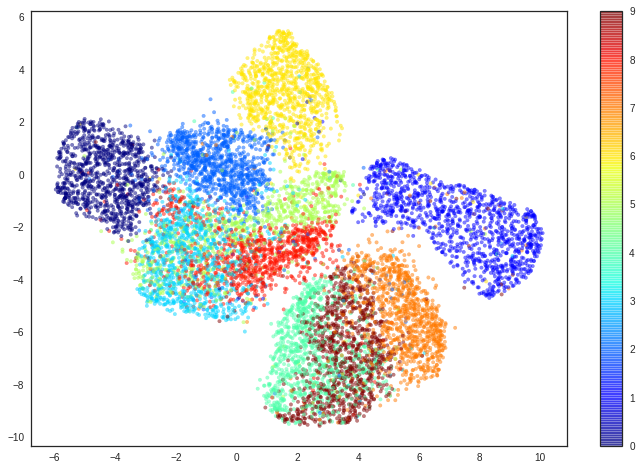

In [170]:
plt.scatter(embedding[:,0], embedding[:,1],c=x_test_label,cmap=plt.cm.jet,alpha=0.5, marker='.')
plt.colorbar()

#### t-SNE

In [0]:
from sklearn.manifold import TSNE

In [172]:
n_sne = 7000

tsne_embedding = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(new_arr)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.054s...
[t-SNE] Computed neighbors for 10000 samples in 25.408s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.406039
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.128471
[t-SNE] Error after 300 iterations: 2.800714


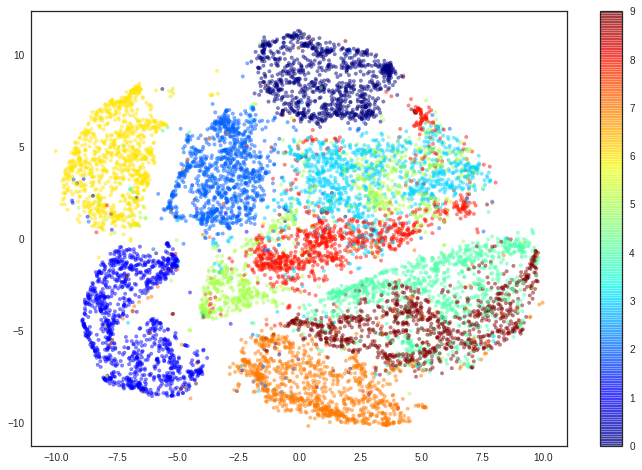

In [173]:
plt.scatter(tsne_embedding[:,0], tsne_embedding[:,1],c=x_test_label,cmap=plt.cm.jet,alpha=0.5, marker='.')
plt.colorbar()

#### PCA

In [0]:
from sklearn.decomposition import PCA

In [0]:
pca_embedding = PCA(n_components=2).fit_transform(new_arr)

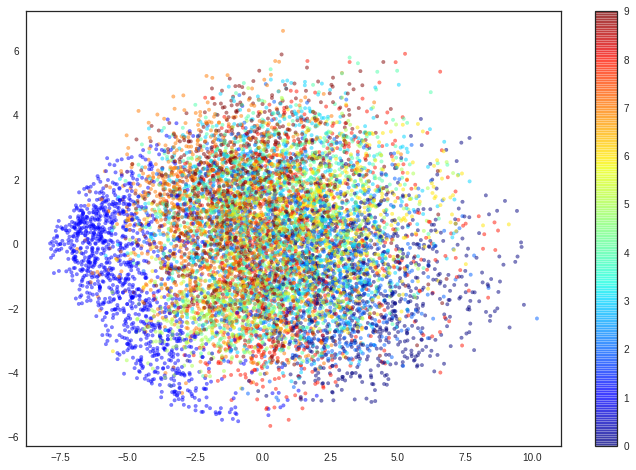

In [176]:
plt.scatter(pca_embedding[:,0], pca_embedding[:,1],c=x_test_label,cmap=plt.cm.jet,alpha=0.5, marker='.')
plt.colorbar()

It's interesting because looking closely at the colors, it seems that 1 is more of an outlier than anything. It is the ONLY outlier in PCA, and no matter what shows up as an outlier everywhere. I wonder if zero is less of an outlier because we left it out -- so it needs to be reconstructed from everything else?

### Clustering Algorithms

I'm going to start with Gaussian Mixture Modeling just because that is what I have experience with and so I understand the theory behind it best. I don't think it will perform well on the PCA reduction, but I'll try it on both UMAP and tSNE

In [0]:
from sklearn.mixture import GaussianMixture

In [0]:
umap_embedding = embedding

In [185]:
umap_gmm = GaussianMixture(n_components=3)
umap_gmm.fit(umap_embedding)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [186]:
print(umap_gmm.means_)
print(umap_gmm.covariances_)

[[-0.45444304 -0.92849986]
 [ 3.91898045 -6.41417723]
 [ 7.49841486 -1.87871039]]
[[[ 5.928269    0.46556118]
  [ 0.46556118  6.3181589 ]]

 [[ 2.38226087  0.92576826]
  [ 0.92576826  2.6887941 ]]

 [[ 2.64124716 -1.25936948]
  [-1.25936948  1.43552792]]]


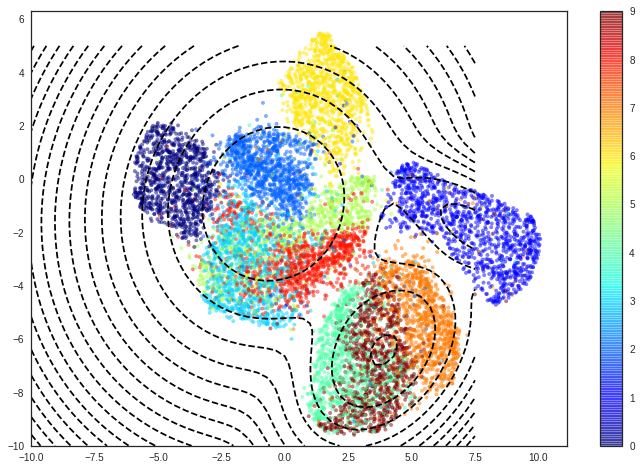

In [187]:
X, Y = np.meshgrid(np.linspace(-10, 7.5), np.linspace(-10,5))
XX = np.array([X.ravel(), Y.ravel()]).T
Z = umap_gmm.score_samples(XX)
Z = Z.reshape((50,50))
 
plt.contour(X, Y, Z,20, colors='k')
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1],c=x_test_label,cmap=plt.cm.jet,alpha=0.5, marker='.')
plt.colorbar()

In [188]:
tsne_gmm = GaussianMixture(n_components=10)
tsne_gmm.fit(tsne_embedding)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=10, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [189]:
print(tsne_gmm.means_)
print(tsne_gmm.covariances_)

[[ 5.50190732  3.64959803]
 [-6.83338322 -4.61999734]
 [-3.17635676  3.63981329]
 [ 3.49831547 -4.56428059]
 [-7.5196661   4.36785766]
 [-1.92978331 -1.79505113]
 [ 1.16574891  8.58558737]
 [ 1.95087427  1.98397587]
 [ 7.65578295 -2.81109337]
 [ 0.44254333 -8.05879978]]
[[[ 1.26027045 -0.35326561]
  [-0.35326561  2.66497521]]

 [[ 1.51140688 -0.91373615]
  [-0.91373615  6.45610696]]

 [[ 1.09922409  0.61072789]
  [ 0.61072789  3.63863548]]

 [[ 4.53558256 -0.09343936]
  [-0.09343936  2.78675237]]

 [[ 1.09851322  0.52504569]
  [ 0.52504569  4.37820439]]

 [[ 4.13883772  1.01146698]
  [ 1.01146698  2.45584229]]

 [[ 2.77951761 -0.57728011]
  [-0.57728011  1.99322999]]

 [[ 2.84492736 -0.95146961]
  [-0.95146961  5.45038777]]

 [[ 1.63174958  0.68003425]
  [ 0.68003425  3.41123768]]

 [[ 4.30404909 -1.66963299]
  [-1.66963299  1.68347497]]]


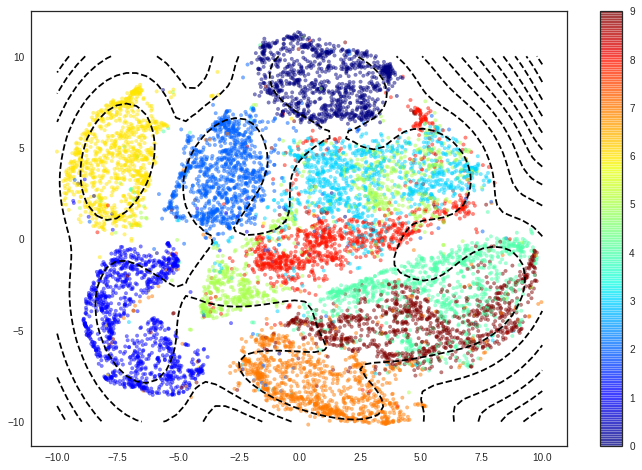

In [190]:
X, Y = np.meshgrid(np.linspace(-10, 10), np.linspace(-10,10))
XX = np.array([X.ravel(), Y.ravel()]).T
Z = tsne_gmm.score_samples(XX)
Z = Z.reshape((50,50))
 
plt.contour(X, Y, Z, 15, colors='k')
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1],c=x_test_label,cmap=plt.cm.jet,alpha=0.5, marker='.')
plt.colorbar()